In [1]:
import netCDF4
import os
import glob
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import sys

In [ ]:
# ETCCDI Climate Change Indicies
# https://etccdi.pacificclimate.org/list_27_indices.shtml

In [2]:
# Define the folder path
data_path = 'test_data\\black_carbon_aerosol_optical_depth_550nm\\'

# Search for all NetCDF files in the folder
netcdf_files = glob.glob(os.path.join(data_path, '*.nc'))

# Search for all NetCDF files in the folder
netcdf_files_err = glob.glob(os.path.join(data_path, '*.nc.error'))
netcdf_files_err = [file.replace('.error','') for file in netcdf_files_err ]

# Remove elements in list2 from list1
netcdf_files = [file for file in netcdf_files if file not in netcdf_files_err]

# Print the list of NetCDF files
for file in netcdf_files:
    print(file)

test_data\black_carbon_aerosol_optical_depth_550nm\2010.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2011.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2012.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2013.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2014.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2015.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2016.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2017.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2018.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2019.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2020.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2021.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2022.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2023.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2024.nc


In [3]:
def convert_seconds_to_date(seconds):
    # Define the start date
    start_date = datetime(1970, 1, 1, 0, 0)
    
    # Calculate the new date by adding the minutes to the start date
    new_date = start_date + timedelta(seconds=seconds)
    
    # Format the new date in hh.mm.dd.mm.yyyy format
    formatted_date = new_date.strftime("%H.%M.%d.%m.%Y")
    
    return new_date#formatted_date

In [4]:
# Open the NetCDF file
file_path = netcdf_files[0]
dataset = netCDF4.Dataset(file_path, 'r')
print(dataset)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    GRIB_centre: ecmf
    GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre: 0
    Conventions: CF-1.7
    institution: European Centre for Medium-Range Weather Forecasts
    history: 2025-04-11T08:41 GRIB to CDM+CF via cfgrib-0.9.15.0/ecCodes-2.39.0 with {"source": "tmppntta8j2/data.grib", "filter_by_keys": {"typeOfLevel": "surface"}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
    dimensions(sizes): valid_time(2920), latitude(11), longitude(13)
    variables(dimensions): int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), float32 bcaod550(valid_time, latitude, longitude)
    groups: 


In [5]:
# Extract the variables
valid_time = dataset.variables['valid_time'][:]
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
x = dataset.variables['bcaod550'][:]  # shape: (time, lat, lon)
# Use broadcasting to create full lat/lon grids
lon_grid, lat_grid = np.meshgrid(longitude, latitude)

# Flatten the spatial dimensions
n_times = len(valid_time)
n_points = lat_grid.size

# Flatten data arrays
flat_lat = lat_grid.ravel()
flat_lon = lon_grid.ravel()
flat_data = x.reshape(n_times, n_points).T  # shape: (points, time)

# Create base DataFrame
data = {
    'latitude': flat_lat,
    'longitude': flat_lon,
}

# Add each time slice as a column
for t_index, t in enumerate(valid_time):
    data[convert_seconds_to_date(int(t))] = flat_data[:, t_index]

# Create DataFrame and GeoDataFrame
df = pd.DataFrame(data)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.drop(columns=['latitude', 'longitude'])
gdf = gdf.set_crs("EPSG:4326", allow_override=True)

# Print the GeoDataFrame
print(gdf)

# Close the dataset
dataset.close()

     2010-01-01 00:00:00  2010-01-01 03:00:00  2010-01-01 06:00:00  \
0               0.000649             0.000618             0.000637   
1               0.000670             0.000679             0.000705   
2               0.000809             0.000808             0.000814   
3               0.000884             0.000913             0.000931   
4               0.001009             0.001046             0.001069   
..                   ...                  ...                  ...   
138             0.001090             0.000964             0.000873   
139             0.001183             0.001000             0.000874   
140             0.001237             0.001014             0.000866   
141             0.001476             0.001176             0.000963   
142             0.001824             0.001474             0.001203   

     2010-01-01 09:00:00  2010-01-01 12:00:00  2010-01-01 15:00:00  \
0               0.000691             0.000230             0.000318   
1               0.0

In [6]:
def netcdfFiles2DF(netcdf_file_paths):
    
    for file_path in netcdf_file_paths:
        # Open the NetCDF file
        dataset = netCDF4.Dataset(file_path, 'r')

        # Extract the variables
        valid_time = dataset.variables['valid_time'][:]
        latitude = dataset.variables['latitude'][:]
        longitude = dataset.variables['longitude'][:]
        x = dataset.variables['bcaod550'][:]  # shape: (time, lat, lon)

        # Use broadcasting to create full lat/lon grids
        lon_grid, lat_grid = np.meshgrid(longitude, latitude)

        # Flatten the spatial dimensions
        n_times = len(valid_time)
        n_points = lat_grid.size

        # Flatten data arrays
        flat_lat = lat_grid.ravel()
        flat_lon = lon_grid.ravel()
        flat_data = x.reshape(n_times, n_points).T  # shape: (points, time)

        # Create base DataFrame
        data = {
            'latitude': flat_lat,
            'longitude': flat_lon,
        }

        # Add each time slice as a column
        for t_index, t in enumerate(valid_time):
            data[convert_seconds_to_date(int(t))] = flat_data[:, t_index]

        # Create DataFrame and GeoDataFrame
        df = pd.DataFrame(data)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
        gdf = gdf.drop(columns=['latitude', 'longitude'])
        gdf = gdf.set_crs("EPSG:4326", allow_override=True)
        try:
            gdf_result = gdf_result.merge(gdf, on='geometry', how='inner')
        except:
            gdf_result = gdf
            
    return gdf_result

gdf_all = netcdfFiles2DF(netcdf_files)
gdf_all

test_data\black_carbon_aerosol_optical_depth_550nm\2010.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2011.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2012.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2013.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2014.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2015.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2016.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2017.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2018.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2019.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2020.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2021.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2022.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2023.nc
test_data\black_carbon_aerosol_optical_depth_550nm\2024.nc


,2010-01-01 00:00:00,2010-01-01 03:00:00,2010-01-01 06:00:00,2010-01-01 09:00:00,2010-01-01 12:00:00,2010-01-01 15:00:00,2010-01-01 18:00:00,2010-01-01 21:00:00,2010-01-02 00:00:00,2010-01-02 03:00:00,...,2024-11-29 18:00:00,2024-11-29 21:00:00,2024-11-30 00:00:00,2024-11-30 03:00:00,2024-11-30 06:00:00,2024-11-30 09:00:00,2024-11-30 12:00:00,2024-11-30 15:00:00,2024-11-30 18:00:00,2024-11-30 21:00:00
0,0.000649,0.000618,0.000637,0.000691,0.000230,0.000318,0.000469,0.000526,0.000451,0.000513,...,0.000756,0.000684,0.000583,0.001004,0.002181,0.002150,0.000939,0.000666,0.000483,0.000576
1,0.000670,0.000679,0.000705,0.000772,0.000270,0.000393,0.000604,0.000716,0.000588,0.000664,...,0.000701,0.000679,0.000545,0.000608,0.001643,0.002085,0.001043,0.000807,0.000562,0.000510
2,0.000809,0.000808,0.000814,0.000865,0.000249,0.000386,0.000678,0.000944,0.000904,0.000925,...,0.000749,0.000752,0.000576,0.000557,0.001157,0.001766,0.001026,0.000930,0.000746,0.000609
3,0.000884,0.000913,0.000931,0.000981,0.000291,0.000465,0.000799,0.001143,0.001111,0.001122,...,0.000839,0.000898,0.000686,0.000576,0.000788,0.001491,0.000990,0.001013,0.000913,0.000748
4,0.001009,0.001046,0.001069,0.001099,0.000389,0.000629,0.000913,0.001217,0.001228,0.001305,...,0.001017,0.001078,0.000792,0.000614,0.000670,0.001248,0.000829,0.000928,0.001020,0.000949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.001090,0.000964,0.000873,0.000867,0.000979,0.001293,0.001745,0.001963,0.003152,0.004629,...,0.000207,0.000259,0.000241,0.000234,0.000254,0.000296,0.000027,0.000082,0.000215,0.000260
139,0.001183,0.001000,0.000874,0.000872,0.000902,0.001220,0.001638,0.001714,0.002426,0.004170,...,0.000220,0.000279,0.000270,0.000279,0.000276,0.000298,0.000024,0.000074,0.000222,0.000272
140,0.001237,0.001014,0.000866,0.000900,0.000918,0.001377,0.001773,0.001699,0.001909,0.003419,...,0.000258,0.000344,0.000337,0.000370,0.000339,0.000357,0.000028,0.000094,0.000266,0.000302
141,0.001476,0.001176,0.000963,0.000925,0.000934,0.001347,0.001593,0.001604,0.001733,0.002587,...,0.000307,0.000431,0.000508,0.000519,0.000446,0.000467,0.000041,0.000175,0.000351,0.000381


In [10]:
# filter geopandas fataframe for distinct timepoints
start_date = 2020
end_date = 2022

# Step 1: Get the column names and remove 'geometry'
date_columns = gdf_all.columns.drop('geometry')

# Step 2: Convert column names to datetime
date_index = pd.to_datetime(date_columns)

# Step 3: Filter for a year range, e.g., start_date–end_date
mask = (date_index.year >= start_date) & (date_index.year <= end_date)
print(mask)
filtered_dates = date_columns[mask]  # These are still strings (original column names)
print(gdf_all[filtered_dates])

[False False False ... False False False]
     2020-01-01 00:00:00  2020-01-01 03:00:00  2020-01-01 06:00:00  \
0               0.000525             0.000556             0.000626   
1               0.000506             0.000539             0.000601   
2               0.000498             0.000541             0.000601   
3               0.000545             0.000598             0.000614   
4               0.000631             0.000689             0.000686   
..                   ...                  ...                  ...   
138             0.000871             0.000701             0.000659   
139             0.000859             0.000689             0.000660   
140             0.000953             0.000742             0.000690   
141             0.001182             0.000949             0.000820   
142             0.001409             0.001213             0.001085   

     2020-01-01 09:00:00  2020-01-01 12:00:00  2020-01-01 15:00:00  \
0               0.000750             0.000957  

In [11]:
print(sys.getsizeof(gdf)) 

def compute_daily_mean(gdf):
    # Extract datetime from column names
    data_only = gdf.drop(columns='geometry')
    # Group columns by date part (ignoring time)
    grouped = {}
    for col in data_only.columns:
        date_only = col.date()  # Extract only the date part
        if date_only not in grouped:
            grouped[date_only] = []
        grouped[date_only].append(col)
    
    # Calculate daily mean
    daily_means = {}
    for date, cols in grouped.items():
        daily_means[date] = data_only[cols].mean(axis=1)
    
    # Create the new DataFrame with daily means
    result = pd.DataFrame(daily_means)
    
    # Add the geometry column back
    result_gdf = gpd.GeoDataFrame(result, geometry=gdf.geometry)
    
    return result_gdf

daily_mean = compute_daily_mean(gdf)
print(daily_mean)

1671528
     2010-01-01  2010-01-02  2010-01-03  2010-01-04  2010-01-05  2010-01-06  \
0      0.000517    0.002980    0.002605    0.000305    0.000345    0.001099   
1      0.000601    0.003162    0.002491    0.000341    0.000470    0.000839   
2      0.000694    0.003270    0.002358    0.000388    0.000931    0.001671   
3      0.000801    0.003212    0.002505    0.000494    0.001425    0.002892   
4      0.000921    0.003218    0.002690    0.000737    0.001988    0.004294   
..          ...         ...         ...         ...         ...         ...   
138    0.001222    0.002614    0.000908    0.001149    0.001527    0.001590   
139    0.001175    0.002688    0.000988    0.000949    0.001137    0.001365   
140    0.001223    0.002782    0.001130    0.000969    0.001037    0.001349   
141    0.001252    0.002803    0.001268    0.001107    0.001099    0.001525   
142    0.001445    0.002844    0.001542    0.001623    0.001471    0.001948   

     2010-01-07  2010-01-08  2010-01-09  20

In [12]:
def compute_mean_across_dates(gdf):
    # Extract datetime columns (excluding the 'geometry' column)
    datetime_cols = [col for col in gdf.columns if col != 'geometry']
    
    # Calculate the mean across all datetime columns for each row (spatial feature)
    data_only = gdf[datetime_cols]
    mean_values = data_only.max(axis=1)
    
    # Add the computed means as a new column
    gdf['mean_across_dates'] = mean_values
    
    return gdf

gdf_with_mean = compute_mean_across_dates(gdf)
print(gdf_with_mean['mean_across_dates'])

0      0.040546
1      0.044556
2      0.050677
3      0.057830
4      0.066445
         ...   
138    0.047937
139    0.044036
140    0.046124
141    0.045437
142    0.048104
Name: mean_across_dates, Length: 143, dtype: float32


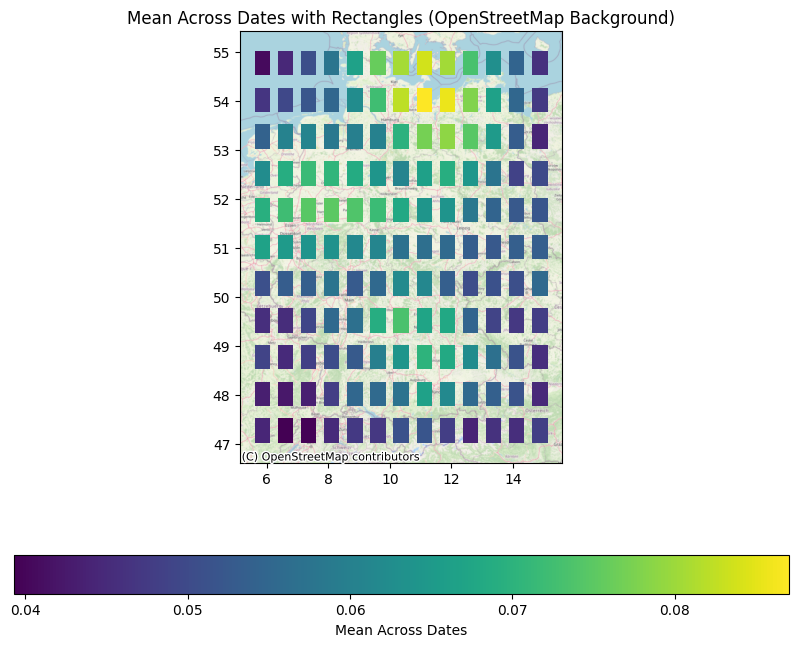

In [15]:
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import box

def plot_mean_as_rectangles_with_osm(gdf, rect_size=0.5):
    # Ensure CRS is set to EPSG:4326

    # Check if geometry is of Point type
    if not gdf.geometry.type.isin(['Point']).all():
        raise ValueError("Geometry must be of type Point for this function")

    # Create a rectangle around each point
    rectangles = []
    for point in gdf.geometry:
        minx, miny = point.x - rect_size / 2, point.y - rect_size / 2
        maxx, maxy = point.x + rect_size / 2, point.y + rect_size / 2
        rectangles.append(box(minx, miny, maxx, maxy))

    # Set the new geometry to be the rectangles
    gdf = gdf.set_geometry(gpd.GeoSeries(rectangles))

    # Plot the GeoDataFrame with OpenStreetMap basemap
    ax = gdf.plot(column='mean_across_dates',
                  cmap='viridis',  # Colormap for color gradient
                  legend=True,
                  figsize=(10, 8),
                  legend_kwds={'label': "Mean Across Dates", 'orientation': "horizontal"})

    # Add OpenStreetMap basemap
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # Title for the plot
    ax.set_title('Mean Across Dates with Rectangles (OpenStreetMap Background)')

    plt.show()
    
plot_mean_as_rectangles_with_osm(gdf_with_mean)

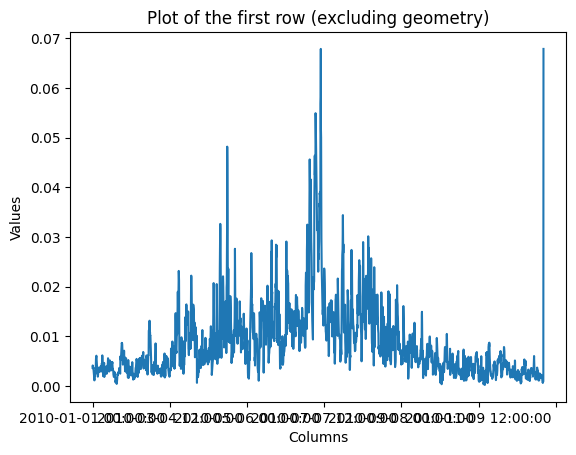

In [16]:


# Select the row to plot (e.g., the first row)
row_to_plot = gdf.iloc[99].drop('geometry')

# Plot the row
row_to_plot.plot()
plt.title('Plot of the first row (excluding geometry)')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

